In [26]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing & Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Model Saving
import joblib
import os

In [27]:
# Load Data
file_path = 'data/processed/wine_quality_cleaned.csv'
df = pd.read_csv(file_path)


In [28]:
# Feature Engineering
df['good_quality'] = (df['quality'] >= 7).astype(int)
df['acid_ratio'] = df['fixed acidity'] / (df['volatile acidity'] + 1e-6)
df['density_alcohol_interaction'] = df['density'] * df['alcohol']

X = df.drop(['quality', 'good_quality'], axis=1)
y_cls = df['good_quality']

In [29]:
# Train-Test Split (Stratified)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.3, random_state=42, stratify=y_cls
)

In [30]:
# Preprocessor
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [31]:
# Baseline Classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_cls, y_train_cls)
baseline_preds = dummy_clf.predict(X_test_cls)
print("--- Baseline Classifier (Most Frequent) ---")
print(classification_report(y_test_cls, baseline_preds))

--- Baseline Classifier (Most Frequent) ---
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1293
           1       0.00      0.00      0.00       303

    accuracy                           0.81      1596
   macro avg       0.41      0.50      0.45      1596
weighted avg       0.66      0.81      0.73      1596



c:\Users\HPi5_\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HPi5_\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HPi5_\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [32]:
# Model 1 - Logistic Regression
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced',
                                      random_state=42, max_iter=1000))
])

logreg_pipeline.fit(X_train_cls, y_train_cls)
y_pred_logreg = logreg_pipeline.predict(X_test_cls)

print("\n--- Logistic Regression Results ---")
print(classification_report(y_test_cls, y_pred_logreg))


--- Logistic Regression Results ---
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      1293
           1       0.40      0.79      0.53       303

    accuracy                           0.74      1596
   macro avg       0.67      0.76      0.67      1596
weighted avg       0.83      0.74      0.76      1596



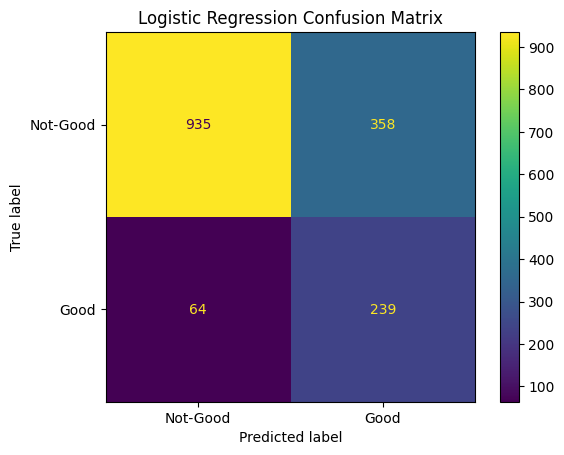

Logistic Regression CV F1-Score (5-fold): 0.5349


In [33]:
cm = confusion_matrix(y_test_cls, y_pred_logreg)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not-Good', 'Good']).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

cv_scores = cross_val_score(logreg_pipeline, X_train_cls, y_train_cls,
                            cv=5, scoring="f1")
print(f"Logistic Regression CV F1-Score (5-fold): {cv_scores.mean():.4f}")

In [34]:
# Model 2 - Gaussian Naive Bayes
gnb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

gnb_pipeline.fit(X_train_cls, y_train_cls)
y_pred_gnb = gnb_pipeline.predict(X_test_cls)

print("\n--- Gaussian Naive Bayes Results ---")
print(classification_report(y_test_cls, y_pred_gnb))


--- Gaussian Naive Bayes Results ---
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1293
           1       0.38      0.68      0.49       303

    accuracy                           0.73      1596
   macro avg       0.65      0.71      0.65      1596
weighted avg       0.81      0.73      0.76      1596



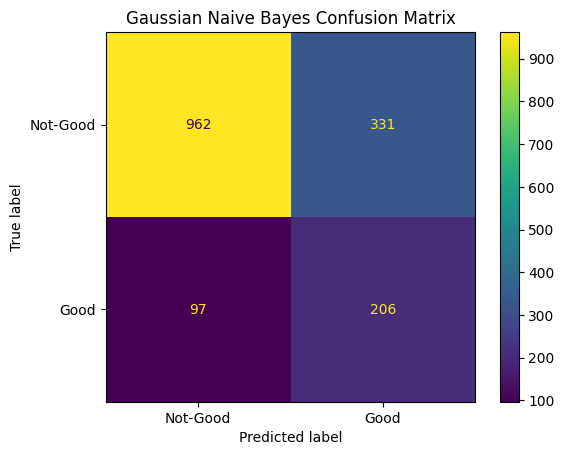

Gaussian NB CV F1-Score (5-fold): 0.5027


In [35]:
cm_gnb = confusion_matrix(y_test_cls, y_pred_gnb)
ConfusionMatrixDisplay(confusion_matrix=cm_gnb, display_labels=['Not-Good', 'Good']).plot()
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()

cv_scores_gnb = cross_val_score(gnb_pipeline, X_train_cls, y_train_cls,
                                cv=5, scoring="f1")
print(f"Gaussian NB CV F1-Score (5-fold): {cv_scores_gnb.mean():.4f}")

In [36]:
# Model 3 - Random Forest Classifier
rf_clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

rf_clf_pipeline.fit(X_train_cls, y_train_cls)
y_pred_rf_clf = rf_clf_pipeline.predict(X_test_cls)

print("\n--- Random Forest Classifier Results ---")
print(classification_report(y_test_cls, y_pred_rf_clf))


--- Random Forest Classifier Results ---
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1293
           1       0.68      0.31      0.43       303

    accuracy                           0.84      1596
   macro avg       0.77      0.64      0.67      1596
weighted avg       0.82      0.84      0.82      1596



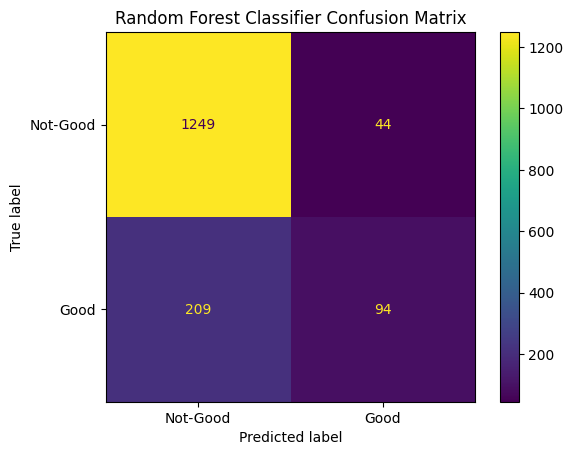

In [37]:
cm_rf = confusion_matrix(y_test_cls, y_pred_rf_clf)
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Not-Good', 'Good']).plot()
plt.title("Random Forest Classifier Confusion Matrix")
plt.show()

In [38]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(class_weight='balanced', probability=True, random_state=42))
])

svm_pipeline.fit(X_train_cls, y_train_cls)
y_pred_svm = svm_pipeline.predict(X_test_cls)

print("\n--- Support Vector Machine (SVM) Results ---")
print(classification_report(y_test_cls, y_pred_svm))


--- Support Vector Machine (SVM) Results ---
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      1293
           1       0.40      0.82      0.54       303

    accuracy                           0.74      1596
   macro avg       0.67      0.77      0.68      1596
weighted avg       0.84      0.74      0.76      1596



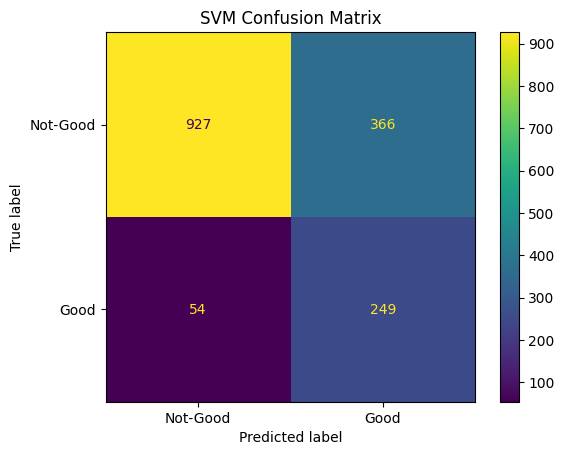

In [45]:
cm_svm = confusion_matrix(y_test_cls, y_pred_svm)
ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Not-Good', 'Good']).plot()
plt.title("SVM Confusion Matrix")
plt.show()

In [46]:
# --- Hyperparameter Tuning for SVM ---
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(estimator=svm_pipeline,
                               param_grid=param_grid_svm,
                               cv=5,
                               scoring='f1',
                               n_jobs=-1,
                               verbose=2)

print("Starting Grid Search for SVM...")
grid_search_svm.fit(X_train_cls, y_train_cls)

print("\nGrid Search Complete for SVM.")
print(f"Best Hyperparameters found: {grid_search_svm.best_params_}")
print(f"Best Cross-Validation F1-Score: {grid_search_svm.best_score_:.4f}")

Starting Grid Search for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Grid Search Complete for SVM.
Best Hyperparameters found: {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Best Cross-Validation F1-Score: 0.5398



--- Tuned SVM Results on Test Set ---
              precision    recall  f1-score   support

           0       0.94      0.72      0.81      1293
           1       0.40      0.82      0.54       303

    accuracy                           0.74      1596
   macro avg       0.67      0.77      0.68      1596
weighted avg       0.84      0.74      0.76      1596



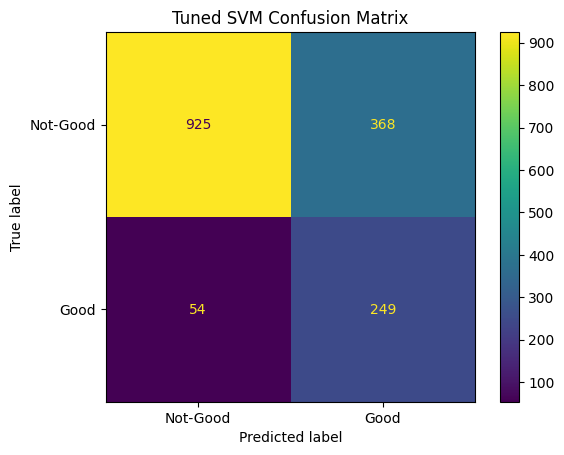

In [47]:
# Evaluate tuned SVM
best_svm_model = grid_search_svm.best_estimator_
y_pred_best_svm = best_svm_model.predict(X_test_cls)

print("\n--- Tuned SVM Results on Test Set ---")
print(classification_report(y_test_cls, y_pred_best_svm))

cm_best_svm = confusion_matrix(y_test_cls, y_pred_best_svm)
ConfusionMatrixDisplay(confusion_matrix=cm_best_svm, display_labels=['Not-Good', 'Good']).plot()
plt.title("Tuned SVM Confusion Matrix")
plt.show()

In [39]:
# Hyperparameter Tuning - Random Forest
param_grid_clf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search_clf = GridSearchCV(estimator=rf_clf_pipeline,
                               param_grid=param_grid_clf,
                               cv=5,
                               scoring='f1',
                               n_jobs=-1,
                               verbose=2)

print("Starting Grid Search for RandomForestClassifier...")
grid_search_clf.fit(X_train_cls, y_train_cls)

print("\nGrid Search Complete.")
print(f"Best Hyperparameters: {grid_search_clf.best_params_}")
print(f"Best Cross-Validation F1-Score: {grid_search_clf.best_score_:.4f}")

Starting Grid Search for RandomForestClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Grid Search Complete.
Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200}
Best Cross-Validation F1-Score: 0.5462


In [40]:
best_clf_model = grid_search_clf.best_estimator_
y_pred_best_clf = best_clf_model.predict(X_test_cls)

print("\n--- Tuned Random Forest Classifier Results on Test Set ---")
print(classification_report(y_test_cls, y_pred_best_clf))


--- Tuned Random Forest Classifier Results on Test Set ---
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1293
           1       0.53      0.67      0.59       303

    accuracy                           0.83      1596
   macro avg       0.72      0.77      0.74      1596
weighted avg       0.84      0.83      0.83      1596



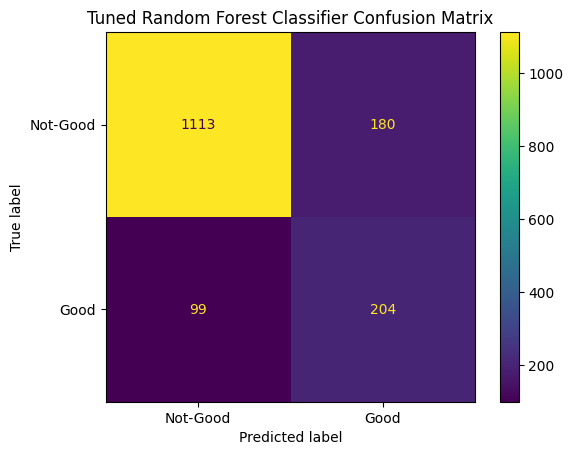

In [41]:
cm_best = confusion_matrix(y_test_cls, y_pred_best_clf)
ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['Not-Good', 'Good']).plot()
plt.title("Tuned Random Forest Classifier Confusion Matrix")
plt.show()

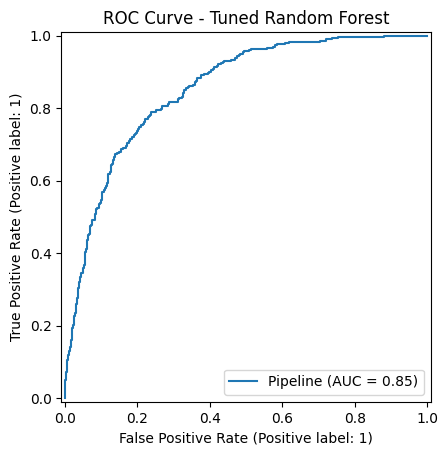

In [42]:
# ROC-AUC Curve (Final Model)
RocCurveDisplay.from_estimator(best_clf_model, X_test_cls, y_test_cls)
plt.title("ROC Curve - Tuned Random Forest")
plt.show()

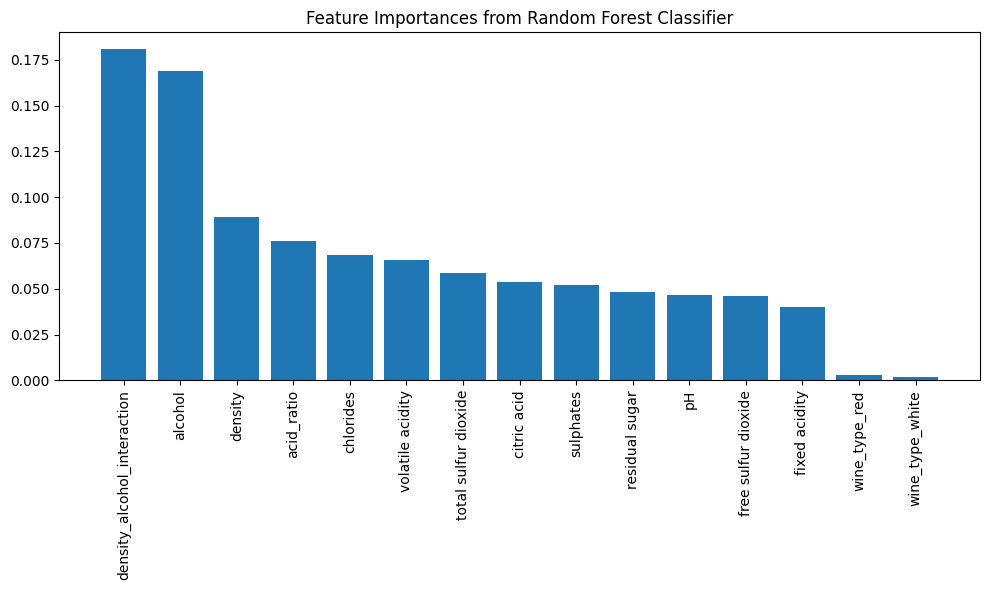

In [43]:
# Feature Importance (RF)
feature_names = (
    numeric_features +
    list(best_clf_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

importances = best_clf_model.named_steps['classifier'].feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_idx], rotation=90)
plt.title("Feature Importances from Random Forest Classifier")
plt.tight_layout()
plt.show()

In [48]:
# Save the Best Model
# ----------------------------
joblib.dump(best_clf_model, "models/best_classifier.pkl")
print("Best classifier saved to models/best_classifier.pkl")

Best classifier saved to models/best_classifier.pkl
